In [1]:
# move to project root
%cd ..
%pwd

/Users/heste/workspace/soccernet/sn-script


'/Users/heste/workspace/soccernet/sn-script'

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import tqdm
from transformers import AutoTokenizer

try:
    from sn_script.config import (
        Config,
        binary_category_name,
        model_type,
    )
    from sn_script.csv_utils import gametime_to_seconds, seconds_to_gametime
except ModuleNotFoundError:
    import sys

    sys.path.append("..")
    from src.sn_script.config import (
        Config,
        binary_category_name,
        model_type,
    )
    from src.sn_script.csv_utils import gametime_to_seconds, seconds_to_gametime

# pandasのprogress_applyを使うために必要
tqdm.pandas()


# CSVの読み込み
LLM_ANOTATION_CSV_1_PATH = (
    Config.target_base_dir / "llm_annotation" / f"{model_type}_500game_{1}_llm_annotation.csv"
)
LLM_ANOTATION_CSV_2_PATH = (
    Config.target_base_dir / "llm_annotation" / f"{model_type}_500game_{2}_llm_annotation.csv"
)
SOCCERNET_LABEL_CSV_PATH = Config.target_base_dir / "misc" / "soccernet_labels.csv"

/Users/heste/workspace/soccernet/sn-script/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Dataframe 表示時の truncation を防ぐ
pd.set_option('display.max_colwidth', None)

In [3]:
import matplotlib
from matplotlib import pylab as plt

# matplotlibのデフォルトフォントをTakaoGothicに設定
font = {"family": "IPAexGothic"}
matplotlib.rc("font", **font)
plt.rcParams.update({"font.size": 22})

In [4]:
soccernet_df = pd.read_csv(SOCCERNET_LABEL_CSV_PATH)

In [5]:
all_game_half_1_df = pd.read_csv(LLM_ANOTATION_CSV_1_PATH, index_col=0)

In [6]:
all_game_half_1_df[["game", "start", "end"]].tail(10)

,game,start,end
id,,,
213344,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:16,44:21
213345,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:18,44:25
213346,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:23,44:29
213347,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:25,44:31
213348,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:29,44:36
213349,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:31,44:40
213350,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:38,44:43
213351,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:41,44:45
213352,spain_laliga/2016-2017/2017-05-21 - 21-00 Mala...,44:43,44:55


In [7]:
all_game_half_1_df["text_length"] = all_game_half_1_df["text"].apply(
    lambda x: len(x.split())
)

In [8]:
# all_game_half_1_df["text_length"].describe()
all_game_half_1_df[all_game_half_1_df["text_length"] > 5000].shape

(22, 9)

In [9]:
all_game_half_1_df[all_game_half_1_df[binary_category_name] == 2].head().to_dict()

{'game': {708: 'england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley',
  1030: 'england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal',
  9233: 'england_epl/2015-2016/2015-09-26 - 17-00 Liverpool 3 - 2 Aston Villa',
  9456: 'england_epl/2015-2016/2015-09-26 - 17-00 Liverpool 3 - 2 Aston Villa',
  9483: 'england_epl/2015-2016/2015-09-26 - 17-00 Liverpool 3 - 2 Aston Villa'},
 'start': {708: '43:17',
  1030: '18:00',
  9233: '17:13',
  9456: '40:57',
  9483: '43:43'},
 'end': {708: '43:21',
  1030: '18:06',
  9233: '17:17',
  9456: '41:03',
  9483: '43:50'},
 'text': {708: 'Está atentísimo Jones para robar ese balón.',
  1030: 'Здорово.',
  9233: 'Развернуться надо и скинуть мяч кому-нибудь.',
  9456: 'Вестфуд, еще одна подача.',
  9483: 'Очень далеко, надбой.'},
 '付加的情報か': {708: 2.0, 1030: 2.0, 9233: 2.0, 9456: 2.0, 9483: 2.0},
 '大分類': {708: nan, 1030: nan, 9233: nan, 9456: nan, 9483: nan},
 '小分類': {708: nan, 1030: nan, 9233: nan, 9456: nan, 9483: nan},
 '備考': 

In [35]:
all_game_half_1_df[all_game_half_1_df[binary_category_name] == -1]["start"].apply(
    gametime_to_seconds
).head(10).to_dict()

{162: 757,
 748: 2692,
 793: 159,
 845: 327,
 847: 327,
 889: 450,
 993: 975,
 1034: 1096,
 1047: 1144,
 1065: 1211}

In [36]:
# 付加的情報を含むコメントをいくつか見てみる

all_game_half_1_df["start_seconds"] = all_game_half_1_df["start"].apply(
    gametime_to_seconds
)

all_game_half_1_df.loc[
    # (all_game_half_1_df[binary_category_name] == 1) &
        (all_game_half_1_df["game"] == "england_epl/2015-2016/2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea") &
        (all_game_half_1_df["start_seconds"] >= 5*60), ["start", "end", "text", binary_category_name]
    ].head(10)

,start,end,text,付加的情報か
id,,,,
4397,05:01,05:08,I think there were uncomfortable headlines.,0.0
4398,05:05,05:12,Cahill.,0.0
4399,05:11,05:21,"Aspilla Queta, and Willian, popping up on the left.",0.0
4400,05:17,05:26,Trying to reverse it back to Hazard.,0.0
4401,05:23,05:31,"Just watching Fernandinho there, just lets Willian run.",0.0
4402,05:27,05:34,Not quite sure why he would.,0.0
4403,05:31,05:37,He's got to pick him up and stay with the run and follow him through.,0.0
4404,05:34,05:53,New look to Bakary Sane this season.,0.0
4405,05:51,05:57,Willian.,0.0


In [37]:
# start を5分ごとにbinningし，[all付加的情報か]の割合をプロットする
all_game_half_1_df["start_bin"] = (
    all_game_half_1_df["start"].apply(gametime_to_seconds) // 300
)


piv_1_df = all_game_half_1_df.pivot_table(
    index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
)
piv_1_df.index = [seconds_to_gametime(i * 300) + "~" for i in piv_1_df.index]
piv_1_df

付加的情報か,-1.0,0.0,1.0,2.0
00:00~,47,17474,4668,9
05:00~,62,19572,3719,16
10:00~,63,20432,3500,21
15:00~,77,21415,3175,24
20:00~,76,20356,3043,22
25:00~,72,20370,2983,21
30:00~,92,20437,2904,25
35:00~,89,21065,2920,23
40:00~,60,20318,2811,25
45:00~,5,1137,208,1


In [38]:
piv_1_df[1.0] / piv_1_df.sum(axis=1)

00:00~    0.210289
05:00~    0.159142
10:00~    0.145736
15:00~    0.128589
20:00~    0.129506
25:00~    0.127229
30:00~    0.123796
35:00~    0.121177
40:00~    0.121091
45:00~    0.153960
dtype: float64

<Axes: title={'center': '前半'}, xlabel='試合時間', ylabel='割合'>

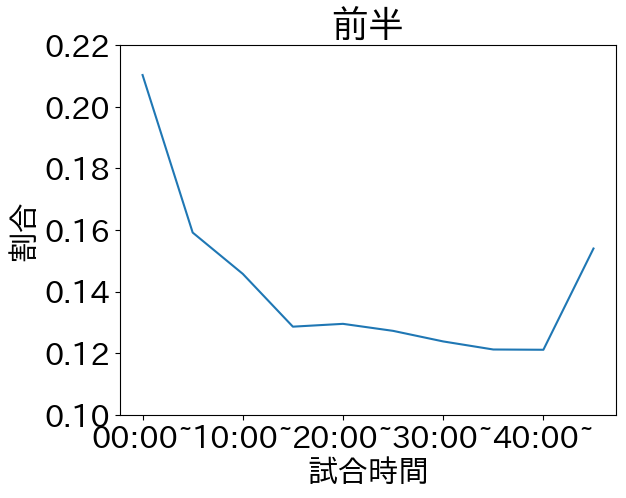

In [39]:
# X軸のラベルをゲーム時間にする
(piv_1_df[1.0] / piv_1_df.sum(axis=1)).plot(
    # xticks=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
    xlabel="試合時間",
    ylabel="割合",
    title="前半",
    ylim=(0.1, 0.22)
)

In [40]:
all_game_half_2_df = pd.read_csv(LLM_ANOTATION_CSV_2_PATH, index_col=0)

In [41]:
# start を5分ごとにbinningし，[all付加的情報か]の割合をプロットする
all_game_half_2_df["start_bin"] = (
    all_game_half_2_df["start"].apply(gametime_to_seconds) // 300
)


piv_2_df = all_game_half_2_df.pivot_table(
    index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
)
half_offset = 2700
piv_2_df.index = [seconds_to_gametime(i * 300 + half_offset) + "~" for i in piv_2_df.index]
piv_2_df

付加的情報か,-1.0,0.0,1.0,2.0
45:00~,51.0,18403.0,3471.0,18.0
50:00~,74.0,20560.0,2867.0,19.0
55:00~,76.0,21288.0,2873.0,12.0
60:00~,94.0,21159.0,2802.0,18.0
65:00~,74.0,20987.0,2801.0,20.0
70:00~,72.0,20555.0,2933.0,22.0
75:00~,79.0,20445.0,2828.0,23.0
80:00~,73.0,20318.0,2740.0,30.0
85:00~,71.0,18917.0,2682.0,16.0
90:00~,17.0,4979.0,767.0,7.0


<Axes: title={'center': '後半'}, xlabel='試合時間', ylabel='割合'>

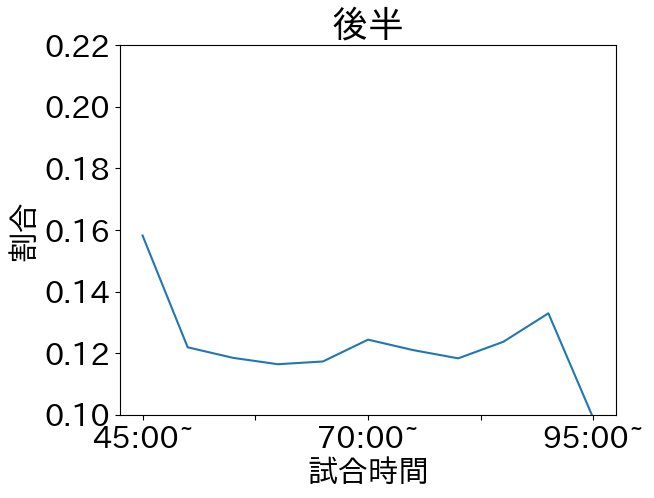

In [42]:
# X軸のラベルをゲーム時間にする
(piv_2_df[1.0] / piv_2_df.sum(axis=1)).plot(
    # xticks=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
    xlabel=u"試合時間",
    ylabel=u"割合",
    title=u"後半",
    ylim=(0.1, 0.22)
)

In [10]:
LLM_ANOTATION_CSV_ALL_PATH = (
    Config.target_base_dir / "llm_annotation" / f"{model_type}_500game_all_llm_annotation.csv"
)
if not LLM_ANOTATION_CSV_ALL_PATH.exists():
    all_game_half_1_df["half"] = 1
    all_game_half_2_df["half"] = 2
    all_game_df = pd.concat([all_game_half_1_df, all_game_half_2_df]).reset_index(drop=True)
    all_game_df.to_csv(LLM_ANOTATION_CSV_ALL_PATH)
else:
    all_game_df = pd.read_csv(LLM_ANOTATION_CSV_ALL_PATH, index_col=0)

def truncate_reduntant_milsec(time_text: str):
    if time_text.count(":")== 0:
        raise ValueError(f"{time_text} is not a valid time text")
    elif time_text.count(":") == 2:
        return ":".join(time_text.split(":")[:2])
    return time_text

# merge game half 1 and 2
all_game_df["start"] = all_game_df["start"].dropna().apply(truncate_reduntant_milsec).apply(gametime_to_seconds)
all_game_df["end"] = all_game_df["end"].dropna().apply(truncate_reduntant_milsec).apply(gametime_to_seconds)

In [11]:
all_game_df["start"]

0            0.0
1            0.0
2            8.0
3            9.0
4           17.0
           ...  
428827    2690.0
428828    2692.0
428829    2694.0
428830    2695.0
428831    2697.0
Name: start, Length: 428865, dtype: float64

In [45]:
# 異常なラベルを削除
# all_game_df = all_game_df[(all_game_df[binary_category_name] == 1) | (all_game_df[binary_category_name] == 0)]

In [24]:
(all_game_df["start"] - all_game_df["start"].shift(1)).describe()

count    428798.000000
mean          0.003573
std         118.256515
min       -3242.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        2738.000000
Name: start, dtype: float64

相関係数: 0.1691280047379889
回帰係数: [0.08477423]
切片: 4.268406797474164


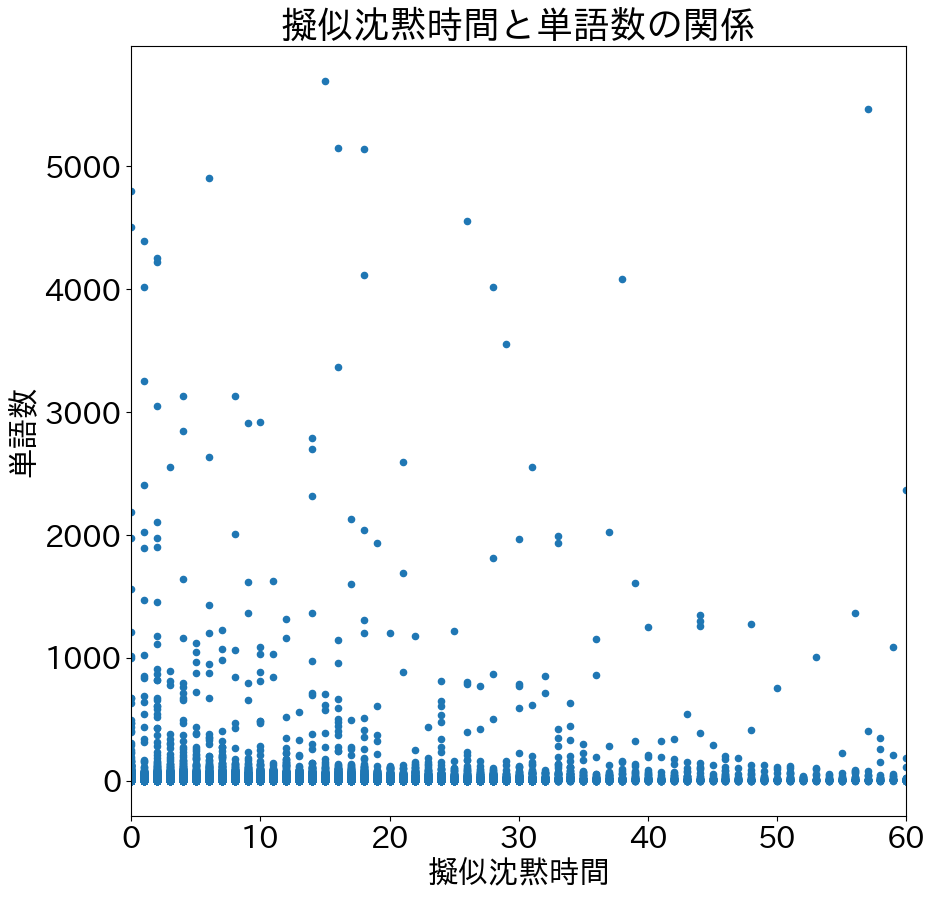

In [25]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


def plot_silence_by_word_count(df: pd.DataFrame):
    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()
    df["false_silence"] = df["start"] - df["start"].shift(1)
    df.loc[df["false_silence"] < 0, "false_silence"] = None
    filtered_df = df.loc[(df['word_count'] >= 0) & (df['false_silence'] >= 0)]


    # 相関係数
    print(f"相関係数: {filtered_df['word_count'].corr(filtered_df['false_silence'])}")
    # 線形回帰
    lr = LinearRegression()
    lr.fit(filtered_df[['word_count']], filtered_df['false_silence'])
    print(f"回帰係数: {lr.coef_}")
    print(f"切片: {lr.intercept_}")

    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_df.plot.scatter(y='word_count', x='false_silence', ax=ax)
    ax.set_xlabel("擬似沈黙時間")
    ax.set_ylabel("単語数")
    ax.set_xlim(0, 60)
    ax.set_title("擬似沈黙時間と単語数の関係")
    fig.savefig("database/images/scbi_v1-silence_by_word_count.png")

plot_silence_by_word_count(all_game_df)

In [46]:
all_game_df[binary_category_name].value_counts(dropna=False)

付加的情報か
 0.0       370387
 1.0        56699
-1.0         1325
 2.0          372
 NaN           66
 5403.0         1
 7321.0         1
 6965.0         1
 6972.0         1
 5174.0         1
 5861.0         1
 5931.0         1
 7744.0         1
 5805.0         1
 5418.0         1
 5475.0         1
 7330.0         1
 9097.0         1
 7286.0         1
 6489.0         1
 7009.0         1
Name: count, dtype: int64

In [47]:
all_game_df.head(30)

,game,start,end,text,付加的情報か,大分類,小分類,備考,text_length,start_bin,half,Unnamed: 12,Unnamed: 13
0,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,0.0,3.0,"Arrancó ya el duelo, maneja la pelota el Barley.",0.0,NaN,NaN,This comment does not contain any supplementary information or statistics.,9.0,0.0,1.0,NaN,NaN
1,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,0.0,9.0,Hay que decir que también se midieron en el primer partido de liga y en aquel encuentro ganó el Chelsea 1-3.,1.0,NaN,NaN,This comment contains historical match data.,21.0,0.0,1.0,NaN,NaN
2,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,8.0,11.0,El Barley se adelantó.,0.0,NaN,NaN,This comment refers to a specific event in the current game.,4.0,0.0,1.0,NaN,NaN
3,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,9.0,18.0,Hay que recordar que se adelantó en ese partido y terminó remontando sin demasiadas dificultades el Chelsea.,1.0,NaN,NaN,This comment contains historical match statistics.,17.0,0.0,1.0,NaN,NaN
4,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,17.0,19.0,"Exactamente, justo lo que iba a decir.",0.0,NaN,NaN,This comment does not contain any supplementary information or statistics.,7.0,0.0,1.0,NaN,NaN
5,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,18.0,20.0,Recuerdo muy bien ese partido.,0.0,NaN,NaN,This comment refers to a specific match and the commentator's personal memory of it.,5.0,0.0,1.0,NaN,NaN
6,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,19.0,24.0,"Empezó bien el Barley, marcó un gol, pero el Chelsea lo ganó cómodo.",0.0,NaN,NaN,This comment contains subjective opinion from commentator.,13.0,0.0,1.0,NaN,NaN
7,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,20.0,31.0,"Por eso hoy tampoco debería tener problemas, pero como bien has dicho, el fútbol es complejo y todo es posible.",0.0,NaN,NaN,This comment is a subjective opinion from the commentator.,20.0,0.0,1.0,NaN,NaN
8,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,30.0,36.0,"Arrancaba con la pelota cuadrado, dejaba para Ivanovic.",0.0,NaN,NaN,This comment does not contain any supplementary information or statistics.,8.0,0.0,1.0,NaN,NaN
9,england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley,33.0,37.0,Ahí está de nuevo cuadrado.,0.0,NaN,NaN,This comment refers to a player's action in the current game.,5.0,0.0,1.0,NaN,NaN


In [31]:
# 発話の時間間隔の平均を計算する (発話の時間間隔:=次の発話の開始時間-前の発話の開始時間)
all_game_df["prev_start"] = all_game_df["start"].shift(1).fillna(0)
all_game_df["prev_end"] = all_game_df["end"].shift(1).fillna(0)
all_game_df["interval"] = all_game_df["start"] - all_game_df["prev_start"]
print(
    all_game_df.loc[all_game_df["interval"] < 0, "interval"].count()
    / all_game_df["interval"].count()
)

0.0019564771285724945


In [32]:
# インターバルがマイナスのものをのぞいて発話感覚の平均を算出
all_game_df.loc[all_game_df["interval"] < 0, "interval"] = pd.NA

start_intarval_mean = all_game_df["interval"].mean(skipna=True)
print(
    f"発話の時間間隔の平均: {start_intarval_mean}秒 ({seconds_to_gametime(start_intarval_mean)})"
)
all_game_df["interval"].describe()

発話の時間間隔の平均: 5.047112920071123秒 (00:05)


count    427993.000000
mean          5.047113
std          24.394889
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        2738.000000
Name: interval, dtype: float64

In [50]:
# 付加的情報を除いた発話の時間間隔の平均を計算する
non_supplemental_df = all_game_df[all_game_df[binary_category_name] == 0]
non_supplemental_df["prev_start"] = non_supplemental_df["start"].shift(1).fillna(0)
non_supplemental_df["prev_end"] = non_supplemental_df["end"].shift(1).fillna(0)
non_supplemental_df["interval_2"] = (
    non_supplemental_df["start"] - non_supplemental_df["prev_start"]
)
print(
    non_supplemental_df.loc[non_supplemental_df["interval_2"] < 0, "interval_2"].count()
    / non_supplemental_df["interval_2"].count()
)

# インターバルがマイナスのものを削除
non_supplemental_df.loc[non_supplemental_df["interval_2"] < 0, "interval_2"] = pd.NA

non_supplemental_start_intarval_mean = non_supplemental_df["interval_2"].mean(
    skipna=True
)
print(
    f"付加的情報を除いた発話の時間間隔の平均: {non_supplemental_start_intarval_mean}秒 ({seconds_to_gametime(non_supplemental_start_intarval_mean)})"
)
non_supplemental_df["interval_2"].describe()

0.0022516988987194473
付加的情報を除いた発話の時間間隔の平均: 5.64380481284146秒 (00:05)


/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_96872/4147113240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_supplemental_df["prev_start"] = non_supplemental_df["start"].shift(1).fillna(0)
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_96872/4147113240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_supplemental_df["prev_end"] = non_supplemental_df["end"].shift(1).fillna(0)
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_96872/4147113240.py:5: SettingWit

count    369553.000000
mean          5.643805
std          22.432183
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        2746.000000
Name: interval_2, dtype: float64

<Axes: title={'center': '付加的情報を除く'}>

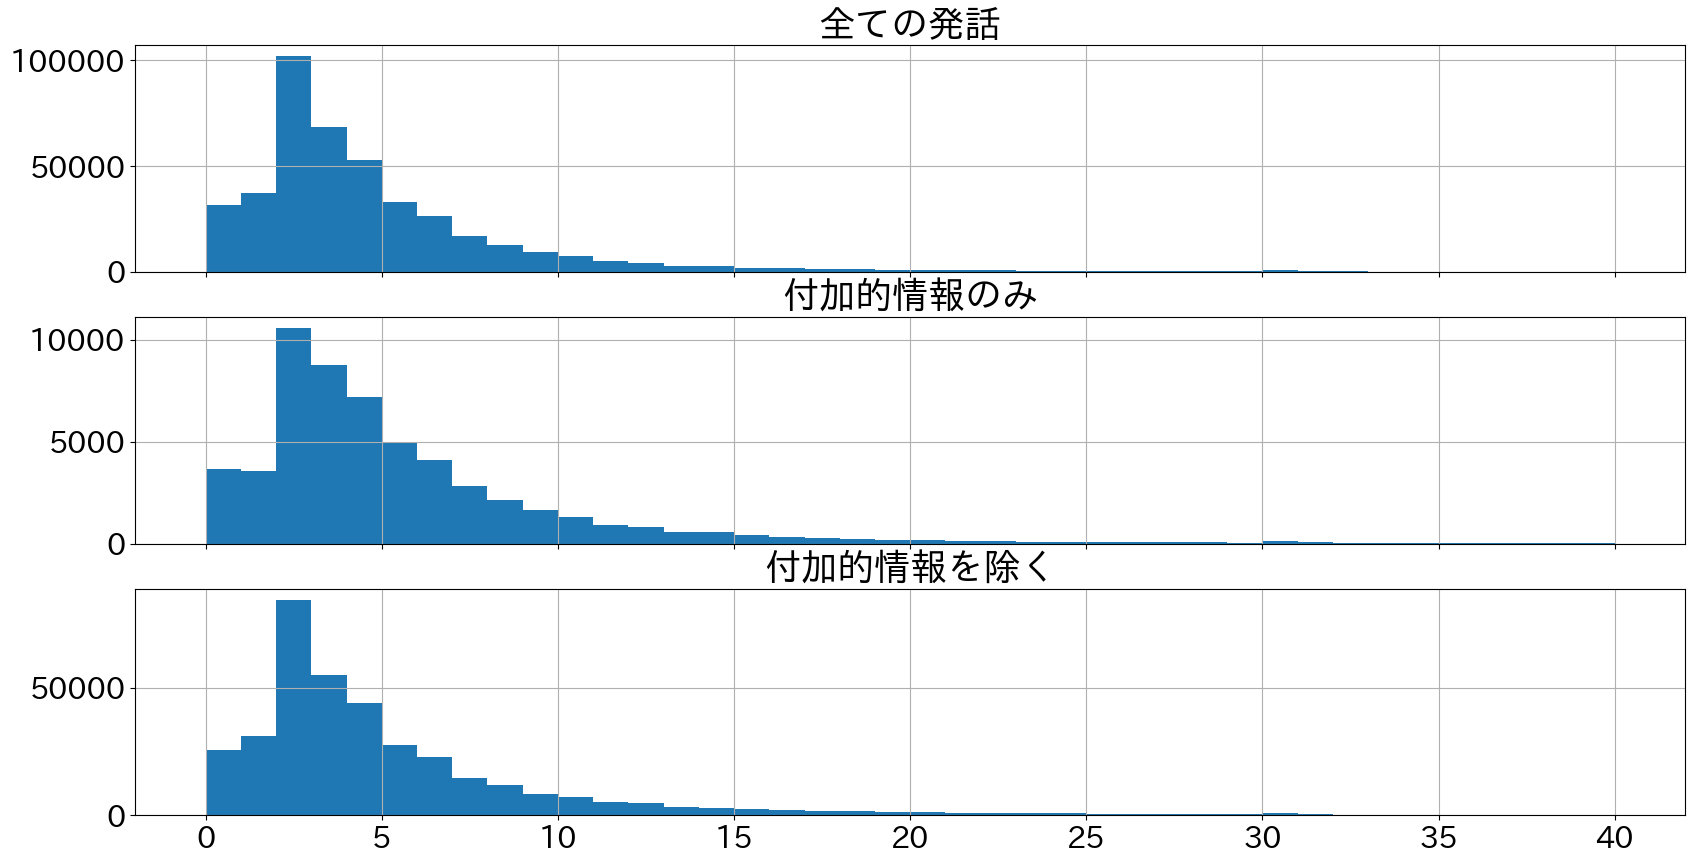

In [51]:
# subplot histgrams
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
ax[0].set_title("全ての発話")
ax[1].set_title("付加的情報のみ")
ax[2].set_title("付加的情報を除く")

all_game_df["interval"].hist(bins=40, range=(0, 40), ax=ax[0])

all_game_df[all_game_df[binary_category_name] == 1]["interval"].hist(
    bins=40, range=(0, 40), ax=ax[1]
)

non_supplemental_df["interval_2"].hist(bins=40, range=(0, 40), ax=ax[2])

In [52]:
# 文字の長さを確認
all_game_df['word_count'] = all_game_df['text'].str.split().str.len()


In [33]:
# インターバルが20秒以上のものを表示
all_game_df["interval_over_20"] = all_game_df["interval"] > 20

# 全コメント　20秒以上の沈黙の後の発話テキストのラベル
rate1 = all_game_df["interval_over_20"].sum() / len(all_game_df)

# 付加的情報のみ　20秒以上の沈黙の後の発話テキストのラベル
rate2 = (
    all_game_df[all_game_df[binary_category_name] == 1]["interval_over_20"].sum()
    / len(all_game_df[all_game_df[binary_category_name] == 1])
)

print(
    "全コメントの20秒インターバル後の発話数:{}\n付加的情報のみの20秒インターバル後の発話数:{}".format(all_game_df["interval_over_20"].sum(), all_game_df[all_game_df[binary_category_name] == 1]["interval_over_20"].sum())
)

print(f"rate1: {rate1:%}\nrate2: {rate2:%}")

# word_countの平均
avg_word_count = all_game_df.loc[
    all_game_df[f"interval_over_20"] == True, # noqa
    'word_count'
].mean()
print(f"word_countの平均: {avg_word_count}")



全コメントの20秒インターバル後の発話数:7047
付加的情報のみの20秒インターバル後の発話数:1505
rate1: 1.643174%
rate2: 2.654368%
word_countの平均: 47.05904897090135


In [34]:
# インターバルが10秒以上のものを表示
interval_length = 10

all_game_df[f"interval_over_{interval_length}"] = all_game_df["interval"] > 10


# 全コメント　20秒以上の沈黙の後の発話テキストのラベル
rate1 = all_game_df[f"interval_over_{interval_length}"].sum() / len(all_game_df)

# 付加的情報のみ　20秒以上の沈黙の後の発話テキストのラベル
rate2 = all_game_df[all_game_df[binary_category_name] == 1][
    f"interval_over_{interval_length}"
].sum() / len(all_game_df[all_game_df[binary_category_name] == 1])

print(
    "全コメントの{}秒インターバル後の発話数:{}\n付加的情報のみの{}秒インターバル後の発話数:{}".format(
        interval_length,
        all_game_df[f"interval_over_{interval_length}"].sum(),
        interval_length,
        all_game_df[all_game_df[binary_category_name] == 1][f"interval_over_{interval_length}"].sum(),
    )
)

print(f"rate1: {rate1:%}\nrate2: {rate2:%}")
# word_countの平均
avg_word_count = all_game_df.loc[
    all_game_df[f"interval_over_10"] == True, # noqa
    'word_count'
].mean()
print(f"word_countの平均: {avg_word_count}")

全コメントの10秒インターバル後の発話数:30170
付加的情報のみの10秒インターバル後の発話数:5908
rate1: 7.034848%
rate2: 10.419937%
word_countの平均: 21.771928661406882


In [35]:
# インターバルが30秒以上のものを表示
interval_length = 30

all_game_df[f"interval_over_{interval_length}"] = all_game_df["interval"] > interval_length


rate1 = all_game_df[f"interval_over_{interval_length}"].sum() / len(all_game_df)

rate2 = all_game_df[all_game_df[binary_category_name] == 1][
    f"interval_over_{interval_length}"
].sum() / len(all_game_df[all_game_df[binary_category_name] == 1])

print(
    "全コメントの{}秒インターバル後の発話数:{}\n付加的情報のみの{}秒インターバル後の発話数:{}".format(
        interval_length,
        all_game_df[f"interval_over_{interval_length}"].sum(),
        interval_length,
        all_game_df[all_game_df[binary_category_name] == 1][
            f"interval_over_{interval_length}"
        ].sum(),
    )
)

print(f"rate1: {rate1:%}\nrate2: {rate2:%}")
# word_countの平均
avg_word_count = all_game_df.loc[
    all_game_df[f"interval_over_30"] == True, # noqa
    'word_count'
].mean()
print(f"word_countの平均: {avg_word_count}")
# 86単語ある->6割弱の確率で付加的情報
# 擬似相関の可能性がある

全コメントの30秒インターバル後の発話数:2835
付加的情報のみの30秒インターバル後の発話数:672
rate1: 0.661047%
rate2: 1.185206%
word_countの平均: 86.75503000352982


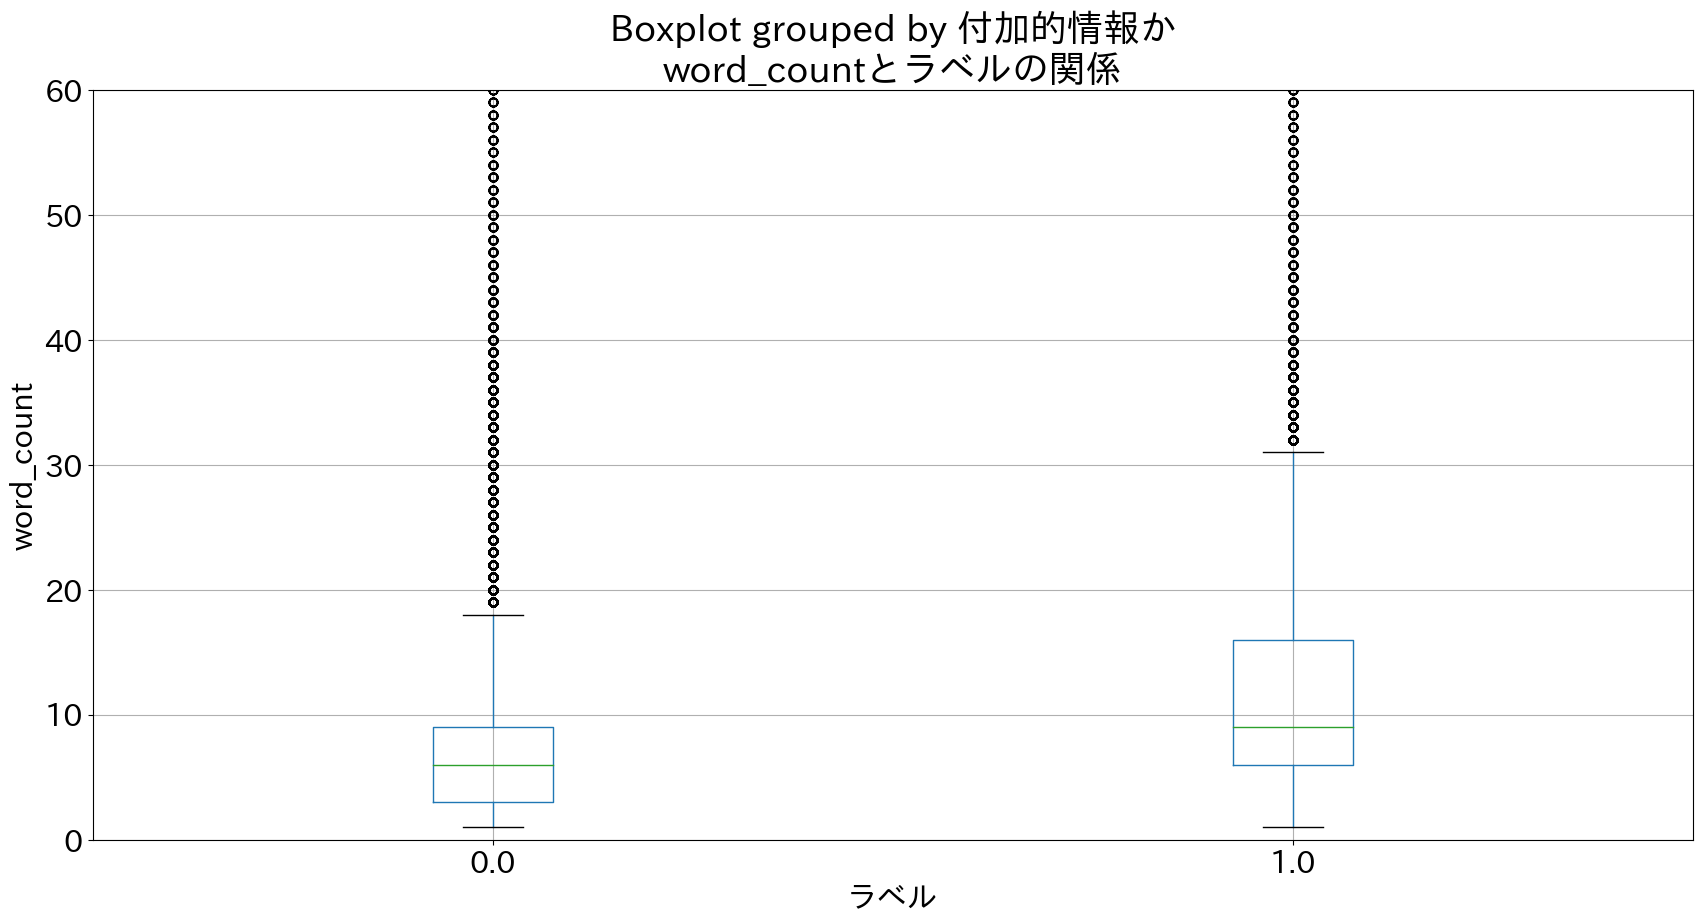

In [65]:
# word_countとラベルの関係 箱ひげ図で可視化
from matplotlib import pyplot as plt

def label_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df = df.loc[df[binary_category_name].isin([0, 1])]
    filtered_df.boxplot(column=column, by=binary_category_name, ax=ax)
    ax.set_ylim(0, 60)
    ax.set_xlabel("ラベル")
    ax.set_ylabel(column)
    ax.set_title(f"{column}とラベルの関係")

label_by_column("word_count", all_game_df)

/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_96872/2406446482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)


 mu: 9.36107030087637, sigma: 53.670341401509255
 xlim: (0, 170)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/heste/workspace/soccernet/sn-script/notebook/database/images/scbi_v2-label_ratio_by_word_count.png'

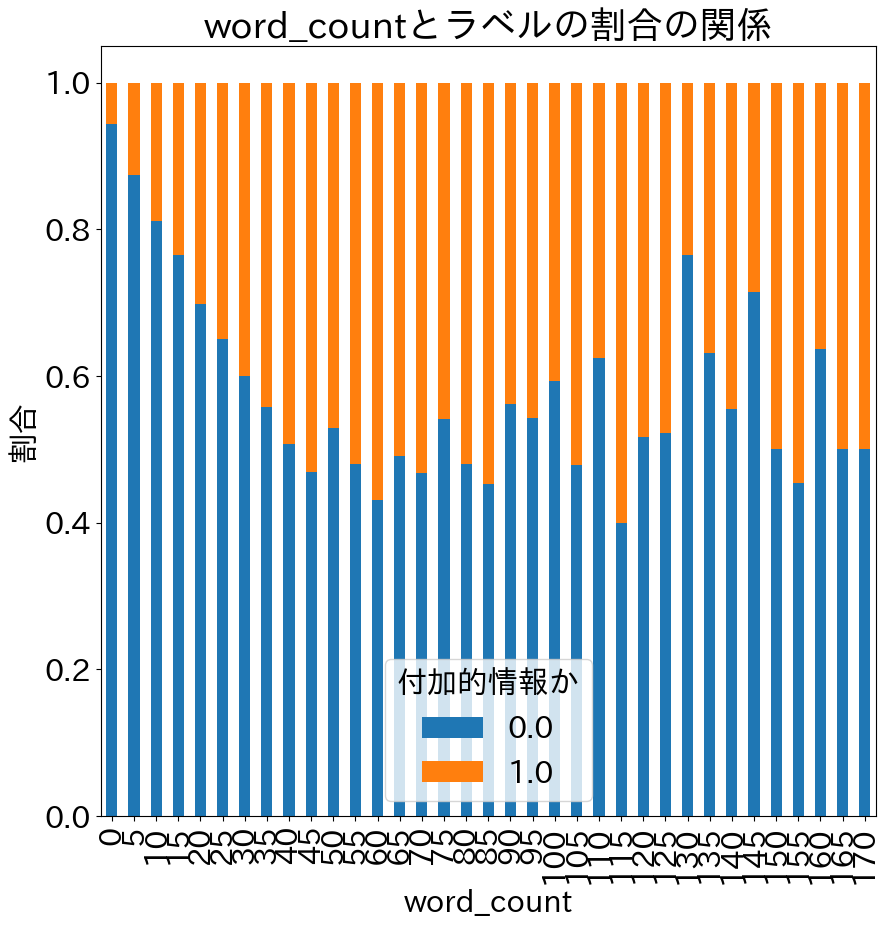

In [66]:
# word_countと binary_category_nameの割合 の相関
def plot_label_ratio_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_df = df.loc[
        (df[binary_category_name].isin([0, 1])) &
        (df[column] > 0)
    ]

    # 5で割って丸めてグルーピング
    filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)

    # xlimを決めるために、word_countの3シグマを計算
    mu = df[column].mean()
    sigma = df[column].std()
    xlim = (max(mu - 3 * sigma, 0), round(mu + 3 * sigma))
    print(f" mu: {mu}, sigma: {sigma}")
    print(f" xlim: {xlim}")

    # xlimの範囲でデータをフィルタリング
    filtered_df = filtered_df.loc[
        (filtered_df[column] >= xlim[0]) & (filtered_df[column] <= xlim[1])
    ]


    piv_df = filtered_df.pivot_table(
        index=column, columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_df = piv_df.fillna(0)
    # 割合に変換?
    piv_df = piv_df.div(piv_df.sum(axis=1), axis=0)

    piv_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
    )

    ax.set_xlabel(column)
    ax.set_ylabel("割合")
    ax.set_title(f"{column}とラベルの割合の関係")

    fig.savefig(f"database/images/scbi_v1-label_ratio_by_{column}.png")


plot_label_ratio_by_column("word_count", all_game_df)

In [56]:
all_game_df.iloc[[54670, 54671]]

,game,start,end,text,付加的情報か,大分類,小分類,備考,text_length,start_bin,half,Unnamed: 12,Unnamed: 13,prev_start,prev_end,interval,word_count,interval_over_20,interval_over_10,interval_over_30
54669,europe_uefa-champions-league/2014-2015/2015-03-10 - 22-45 Real Madrid 3 - 4 Schalke,1391.0,1447.0,"Yeah It's caught the arm of Sami Khedira, he didn't travel very far, there was no intent Ronaldo finding Bale This is because Chupo Moting is down injured in Real Madrid half, crosses from Quentral dealt with by Fuchs the goal scorer, there is a problem with the Schalke striker Eric Meks and Chupo Moting He mentioned the referee this evening, is the experienced Slovenian dummy a stromina?",0.0,NaN,NaN,The comment contains a mix of unclear and irrelevant information.,68.0,4.0,1.0,NaN,NaN,1299.0,1393.0,92.0,68.0,True,True,True
54670,europe_uefa-champions-league/2014-2015/2015-03-10 - 22-45 Real Madrid 3 - 4 Schalke,1438.0,1490.0,"No not from me, it's too close, he's rolled up off his foot You've got no idea where that's coming off your foot like that, no no no This is Chupo Moting, maybe just catches one there on his ankle here, for a swing at the corner, oh it's a good header and a really really important goal for Nuno who Cristiano Ronaldo scores, a little bit of sanity returns to the Bernabeu Carlo Ancelotti's go-to man, makes it 40 for the season again, he scored over 50 in each of the last four seasons here, greatly, stunning header that is, is his mark seriously close there?",1.0,NaN,NaN,This comment contains detailed play-by-play description of the match.,107.0,4.0,1.0,NaN,NaN,1391.0,1447.0,47.0,107.0,True,True,True


In [57]:
all_game_df.iloc[[251678, 251679, 251680]]

,game,start,end,text,付加的情報か,大分類,小分類,備考,text_length,start_bin,half,Unnamed: 12,Unnamed: 13,prev_start,prev_end,interval,word_count,interval_over_20,interval_over_10,interval_over_30
251662,england_epl/2016-2017/2017-01-02 - 18-00 Sunderland 2 - 2 Liverpool,1367.0,1371.0,Just trying to shake off that knock.,0.0,NaN,NaN,This comment refers to a player's current physical condition.,NaN,4.0,2.0,NaN,NaN,1364.0,1369.0,3.0,7.0,False,False,False
251663,england_epl/2016-2017/2017-01-02 - 18-00 Sunderland 2 - 2 Liverpool,1369.0,1379.0,Lallana.,0.0,NaN,NaN,This comment simply refers a player name.,NaN,4.0,2.0,NaN,NaN,1367.0,1371.0,2.0,1.0,False,False,False
251664,england_epl/2016-2017/2017-01-02 - 18-00 Sunderland 2 - 2 Liverpool,1377.0,1381.0,Firmino.,0.0,NaN,NaN,This comment simply refers a player name.,NaN,4.0,2.0,NaN,NaN,1369.0,1379.0,8.0,1.0,False,False,False


Jurgen Klopp has been playing a few mind games...

In [58]:
# 文字数の比較
all_game_df[all_game_df[binary_category_name] == 0]["text_length"].describe()


count    182571.000000
mean          8.067689
std          36.022237
min           1.000000
25%           3.000000
50%           6.000000
75%          10.000000
max        5347.000000
Name: text_length, dtype: float64

In [59]:
# 文字数の比較
all_game_df[all_game_df[binary_category_name] == 1]["text_length"].describe()

count    29923.000000
mean        19.525181
std        131.634010
min          1.000000
25%          6.000000
50%         10.000000
75%         16.000000
max       6084.000000
Name: text_length, dtype: float64

In [60]:
all_game_df.iloc[[1932, 1933, 1934]]["text"].tolist()

["He's got a great run.",
 'Walt Browse to try and orchestrate something here for Southampton.',
 'Mignolet.']

In [61]:
# 内容の違いを確認
print(all_game_df["text"].sample(20).to_dict())
print("-------------")
print(all_game_df[all_game_df["interval_over_30"] == 1]["text"].sample(20).to_dict())
# 例：The Belgian international who was injured here in Basel, made it back for the UEFA Europa League final which Liverpool lost to Sevilla.

{'220861': 'Mais on aurait eu peut-être encore moins de suspect.', '209509': 'Recupera el balón al Granada.', '170166': 'Y la verdad Michael es que hay que preguntarse qué opinan los amigos de Big Win alrededor de las posibilidades de gol de los distintos goleadores que tiene el partido.', '274104': 'Bartek.', '269349': "This lad's a step up, really, I think.", '428488': 'Incorto para Marcelo.', '341058': 'Посмотрим, посмотрим, кто будет бить.', '182746': 'En aquel costado presiona Oyarzabal, también Zurutuzza que actuó por delante.', '305571': 'Le décalage une nouvelle fois avec Sisoko le centre contré.', '398308': 'Entra Isco.', '70738': 'Vuruyor Cezar.', '9460': 'Как же так можно было его партнерам не откликнуться на эту скидку.', '135032': 'Эмерсон все активнее.', '146219': 'Дероси против Шкринера, уступая ему в рост, но пытается завязать его по-боксерски захватом.', '234821': 'Intenta llegar McLean.', '108305': 'Ich versuch es mal.', '66379': 'Heureusement Cels reste bien sur ses 

In [38]:
for interval_length in [10, 20, 30]:
    all_game_df["text_length"] = all_game_df["text"].str.split().str.len()
    text_length_normal_interval = all_game_df["text_length"].mean()
    text_length_long_interval = all_game_df[
        (all_game_df[f"interval_over_{interval_length}"] == 1)]["text_length"].mean()
    print(
        f"文字数の平均: {text_length_normal_interval}\nインターバル{interval_length}秒のあとの文字数の平均: {text_length_long_interval}"
    )


文字数の平均: 9.36107030087637
インターバル10秒のあとの文字数の平均: 21.771928661406882
文字数の平均: 9.36107030087637
インターバル20秒のあとの文字数の平均: 47.05904897090135
文字数の平均: 9.36107030087637
インターバル30秒のあとの文字数の平均: 86.75503000352982


In [36]:
# 付加的情報のうち、長いインターバルのあとの発話の文字数と、そうではない場合の発話の文字数の平均を比較
for interval_length in [10, 20, 30]:
    all_game_df["text_length"] = all_game_df["text"].str.split().str.len()
    text_length_normal_interval = all_game_df[all_game_df[binary_category_name] == 1]["text_length"].mean()
    text_length_long_interval = all_game_df[
        (all_game_df[binary_category_name] == 1)
        & (all_game_df[f"interval_over_{interval_length}"] == 1)]["text_length"].mean()
    print(
        f"付加的情報の文字数の平均: {text_length_normal_interval}\n付加的情報のインターバル{interval_length}秒のあとの文字数の平均: {text_length_long_interval}"
    )

付加的情報の文字数の平均: 18.853330275876665
付加的情報のインターバル10秒のあとの文字数の平均: 52.891503046716316
付加的情報の文字数の平均: 18.853330275876665
付加的情報のインターバル20秒のあとの文字数の平均: 119.63255813953488
付加的情報の文字数の平均: 18.853330275876665
付加的情報のインターバル30秒のあとの文字数の平均: 216.4375


In [ ]:
all_game_df[
    (all_game_df[binary_category_name] == 1)
]["text_length"].describe()

In [ ]:
all_game_df[
    (all_game_df[binary_category_name] == 1) & (all_game_df["interval_over_30"] == 1)
]["text_length"].describe()

In [ ]:
all_game_df[
    (all_game_df[binary_category_name] == 1) & (all_game_df["interval_over_20"] == 1)
]["text_length"].describe()

In [ ]:
all_game_df[
    (all_game_df[binary_category_name] == 1) & (all_game_df["interval_over_30"] == 1)
]["text_length"].hist(bins=40, range=(0, 2000))

In [26]:
# 外れ値を除去
# データを大きいものから順番に並べて4等分する（分割点が四分位数）
# 「四分位範囲（IQR）＝第3四分位数（Q3） － 第1四分位数（Q1）」
# upper_bound = 「第3四分位数+1.5×IQRより小さい最大値」
# lower_bound =「第1四分位数-1.5×IQRより大きい最小値」


upper_bound = all_game_df[all_game_df[binary_category_name] == 1][
    "text_length"
].quantile(0.75) + 1.5 * (
    all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.75)
    - all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.25)
)
lower_bound = all_game_df[all_game_df[binary_category_name] == 1][
    "text_length"
].quantile(0.25) - 1.5 * (
    all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.75)
    - all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.25)
)


text_length_normal_interval = all_game_df[
    (all_game_df[binary_category_name] == 1)
    & (all_game_df["text_length"] < upper_bound)
    & (lower_bound < all_game_df["text_length"])
]["text_length"].mean()
text_length_long_interval = all_game_df[
    (all_game_df[binary_category_name] == 1)
    & (all_game_df["interval_over_30"] == 1)
    & (all_game_df["text_length"] < upper_bound)
    & (lower_bound < all_game_df["text_length"])
]["text_length"].mean()
print(
    f"付加的情報の文字数の平均: {text_length_normal_interval}\n付加的情報の長いインターバルのあとの文字数の平均: {text_length_long_interval}"
)

KeyError: 'interval_over_30'

In [ ]:
# 外れ値を除去
upper_bound = all_game_df[all_game_df[binary_category_name] == 1][
    "text_length"
].quantile(0.75) + 1.5 * (
    all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.75)
    - all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.25)
)
lower_bound = all_game_df[all_game_df[binary_category_name] == 1][
    "text_length"
].quantile(0.25) - 1.5 * (
    all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.75)
    - all_game_df[all_game_df[binary_category_name] == 1]["text_length"].quantile(0.25)
)


text_length_normal_interval = all_game_df[
    (all_game_df[binary_category_name] == 1)
    & (all_game_df["text_length"] < upper_bound)
    & (lower_bound < all_game_df["text_length"])
]["text_length"].mean()
text_length_long_interval = all_game_df[
    (all_game_df[binary_category_name] == 1)
    & (all_game_df["interval_over_20"] == 1)
    & (all_game_df["text_length"] < upper_bound)
    & (lower_bound < all_game_df["text_length"])
]["text_length"].mean()
print(
    f"付加的情報の文字数の平均: {text_length_normal_interval}\n付加的情報の長いインターバルのあとの文字数の平均: {text_length_long_interval}"
)

In [ ]:
# 発話区間の長さの調査
# ポアソン分布っぽい形をしている

fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
ax[0].set_title("全ての発話")
ax[1].set_title("付加的情報を含む")
ax[2].set_title("付加的情報を含まない")

all_game_df["duration"] = all_game_df["end"] - all_game_df["start"]

all_game_df["duration"].hist(bins=40, range=(0, 40), ax=ax[0])
all_game_df[all_game_df[binary_category_name] == 1]["duration"].hist(
    bins=40, range=(0, 40), ax=ax[1]
)
all_game_df[all_game_df[binary_category_name] == 0]["duration"].hist(
    bins=40, range=(0, 40), ax=ax[2]
)

In [ ]:
# ゲームごとにグループ化
grouped = all_game_df.groupby("game")

# is overlapped
all_game_df["is_overlapped"] = False

# オーバーラップの集計用変数
total_overlaps = 0
total_overlap_duration = 0

# 各ゲームのグループをループ処理
for game, group in grouped:
    # 開始時間に基づいてソート
    sorted_group = group.sort_values(by="start")

    # オーバーラップを検出し計算
    for i in range(len(sorted_group) - 1):
        current_end = sorted_group.iloc[i]["end"]
        next_start = sorted_group.iloc[i + 1]["start"]
        if current_end > next_start:
            # flag
            all_game_df.loc[sorted_group.index[i], "is_overlapped"] = True
            total_overlaps += 1
            overlap_duration = current_end - next_start
            total_overlap_duration += overlap_duration

# 統計量を表示
print(f"Total number of overlaps across all games: {total_overlaps}")
print(
    f"Total duration of overlaps across all games (in seconds): {total_overlap_duration}"
)


In [ ]:
print(f"1つオーバーラップの平均秒数: {total_overlap_duration / total_overlaps}")

In [ ]:
# 発話数
print(f"発話数 {len(all_game_df)}")
# 1試合あたりの平均発話数
mean_speech_count = len(all_game_df) / len(grouped)
print(f"1試合あたりの平均発話数 {mean_speech_count}")

# 1発話あたりの平均文字数
print(f"1発話あたりの平均文字数 {all_game_df['text_length'].mean()}")
print(
    f"付加的情報の1発話あたりの平均文字数 {all_game_df[all_game_df[binary_category_name] == 1]['text_length'].mean()}"
)

# 1発話あたりの平均発話時間
print(f"1発話あたりの平均発話時間 {all_game_df['duration'].mean()}")
print(
    f"付加的情報の1発話あたりの平均発話時間 {all_game_df[all_game_df[binary_category_name] == 1]['duration'].mean()}"
)

# 発話間の平均沈黙時間
print(f"発話間の平均沈黙時間 {all_game_df['interval'].mean()}")
print(
    f"付加的情報の発話の平均沈黙時間 {all_game_df[all_game_df[binary_category_name] == 1]['interval'].mean()}"
)

# 発話のオーバーラップの割合
print(f"発話のオーバーラップの割合 {all_game_df['is_overlapped'].sum() / len(all_game_df)}")
print(
    f"付加的情報の発話のオーバーラップの割合 {all_game_df[all_game_df[binary_category_name] == 1]['is_overlapped'].sum() / len(all_game_df[all_game_df[binary_category_name] == 1])}"
)

In [ ]:
# 遷移確率の調査
# 試合ごとに，0 -> 1, 1-> 0, 1 -> 1, 0 -> 0 の割合を算出し，平均をとる

elminated_game_df = all_game_df[
    (all_game_df[binary_category_name] == 1) | (all_game_df[binary_category_name] == 0)
]
grouped = elminated_game_df[
    (all_game_df[binary_category_name] == 1) | (all_game_df[binary_category_name] == 0)
].groupby("game")

buffer = []

for game, group in grouped:
    # 開始時間に基づいてソート
    sorted_group = group.sort_values(by="start")

    for i in range(len(sorted_group) - 1):
        current_label = sorted_group.iloc[i][binary_category_name]
        next_label = sorted_group.iloc[i + 1][binary_category_name]
        assert current_label in [0, 1]
        assert next_label in [0, 1]
        buffer.append(
            {
                "game": game,
                "0_to_1": (current_label == 0 and next_label == 1),
                "1_to_0": (current_label == 1 and next_label == 0),
                "1_to_1": (current_label == 1 and next_label == 1),
                "0_to_0": (current_label == 0 and next_label == 0),
            }
        )

transition_df = pd.DataFrame(buffer)

In [ ]:
print("elminated_game_df", len(elminated_game_df))
print("transition_df", len(transition_df))


In [ ]:
# 1試合あたりの平均沈黙時間
all_game_df["interval_true"] = all_game_df["start"] - all_game_df["prev_end"]

all_game_df.loc[all_game_df["interval_true"] < 0, "interval_true"] = pd.NA
all_game_df["interval_true"] = all_game_df["interval_true"].fillna(0)

print(f"1試合あたりの平均沈黙時間 {all_game_df.groupby('game')['interval_true'].mean().mean()}")

In [ ]:
all_game_df["interval_true"].describe()

In [ ]:
# インターバルが30秒以上のものを表示
for interval_length in [10, 20, 30]:
    all_game_df[f"interval_true_over_{interval_length}"] = (
        all_game_df["interval_true"] > interval_length
    )
    # 全コメント　interval_length秒以上の沈黙の後の発話テキストのラベル
    rate1 = all_game_df[f"interval_true_over_{interval_length}"].sum() / len(all_game_df)

    # 付加的情報のみ　interval_length秒以上の沈黙の後の発話テキストのラベル
    rate2 = all_game_df[all_game_df[binary_category_name] == 1][
        f"interval_true_over_{interval_length}"
    ].sum() / len(all_game_df[all_game_df[binary_category_name] == 1])

    print(
        "全コメント{}秒インターバル後の発話数:{}\n付加的情報のみの{}秒インターバル後の発話数:{}".format(
            interval_length,
            all_game_df[f"interval_true_over_{interval_length}"].sum(),
            interval_length,
            all_game_df[all_game_df[binary_category_name] == 1][
                f"interval_true_over_{interval_length}"
            ].sum(),
        )
    )

    print(f"rate1: {rate1}\nrate2: {rate2}")

In [ ]:
count, division = np.histogram(all_game_df["interval_true"], bins=40, range=(0, 40))
count = count / count.sum()
plt.bar(division[:-1], count, width=1)

In [ ]:
all_game_df[["start","end",  "prev_end", "interval_true"]].head(100)

In [ ]:
# soccernet_dfの前処理
soccernet_df["time"] = soccernet_df["time"].apply(gametime_to_seconds)
soccernet_df["start"] = soccernet_df["time"] - 5
soccernet_df["end"] = soccernet_df["time"] + 5

# game, half, time でソート
soccernet_df = soccernet_df.sort_values(by=["game", "half", "time"])

In [ ]:
import nltk

nltk.download("punkt")

text = "Thank you Connor right on cue and as we were suggesting the first half well Breton Rogers has gone for Alberto Moreno for the second half Joe Gomez request to right back now it seems as Scotland love for Ndombe the centre-back partnership here is Milner early touch for Moreno, Jose Gomez in about three Skirball Liverpool will look to find the start of the second half along the lines that West Ham found in the first that's worked on to Klein managed to keep it in play but wait for a West Ham goal kick so Brendan Rogers tinkered with his formation last season it looks like now with that Klein playing as a right wing back maybe Moreno left wing back and maybe more comfortable position for Joe Gomez alongside Skirtland Lovren yes I think he'll be comfortable there obviously he can use his pace as a three as such but they need to do something and now you've got the likes of Klein Moreno in advanced areas and they've got good quality when they do get in there and hopefully they'll be looking to find that killer pass"

li = nltk.sent_tokenize(text)
print(len(li))

In [ ]:
# get unique words
from nltk.tokenize import word_tokenize


def calculate_vocabulary_size(corpus):
    # コーパスをトークン化
    tokens = word_tokenize(corpus)

    # トークンのセットを作成して重複を排除し、語彙数を計算
    vocabulary = set(tokens)
    return len(vocabulary)


# ここにコーパステキストを入力します。この例では英語のテキストを使用していますが、
# 空白で単語が区切られている任意の言語に適用可能です。
corpus_text = all_game_df["text"].str.cat(sep=" ")

vocabulary_size = calculate_vocabulary_size(corpus_text)
print(f"Vocabulary Size: {vocabulary_size}")

In [ ]:
soccernet_labels = soccernet_df["label"].unique().tolist()
print("Unique labels:")
print(*soccernet_labels[1:], sep="\n") # nanを除く

In [ ]:
"""
soccernet_df の importantなコメントの前後5秒に含まれる，all_game_dfの実況コメントのラベルの割合を調べる手順
1. all_game_dfの書くコメントの is_important を False で初期化
2. soccernet_df を game でグループ化する
2. game ごとに，
    - soccernet_dfの各行について，important が True なら，all_game_dfの start が soccernet_dfの start, end に含まれるかを計算する
    - 含まれるなら，all_game_dfのカラムに[is_important]を追加し，Trueにする
3. all_game_df[is_important] = True の付加的情報かの割合を計算する
"""
all_game_df["is_important"] = False
grouped_soccernet = soccernet_df.groupby("game")

for game, soccernet_group in tqdm(grouped_soccernet):
    for i, row in soccernet_group.iterrows():
        if not row["important"]:
            continue

        start = row["start"]
        end = row["end"]
        half = row["half"]
        # all_game_dfを直接更新するために、適切なインデックスを取得
        all_game_indexes = all_game_df[
            (all_game_df["game"] == game)
            & (all_game_df["half"] == half)
            & (all_game_df["start"] >= start)
            & (all_game_df["start"] <= end)
        ].index

        all_game_df.loc[all_game_indexes, "is_important"] = True  # 時間かかる

In [ ]:
# is_importantがTrueの行の割合を計算
important_count = len(all_game_df[all_game_df["is_important"] is True])
total_count = len(all_game_df)
important_ratio = important_count / total_count * 100

print(f"推定の重要コメント数 {important_count}")

important_addition_count = len(
    all_game_df[
        (all_game_df["is_important"] is True) & (all_game_df[binary_category_name] == 1)
    ]
)
other_comment = important_count - important_addition_count

print(f"推定の重要コメントの付加的情報の割合 {important_addition_count / important_count * 100}%")
print(f"推定の重要コメントの付加的情報以外の割合 {other_comment / important_count * 100}%")

In [ ]:
# important と同じ処理を，soccernet_df の label(y-card, whisle, soccer-ball, etc...) の各項目ごとに行う
soccernet_labels = soccernet_df["label"].unique()
grouped_soccernet = soccernet_df.groupby("game")

for action_label in tqdm(soccernet_labels):
    all_game_df[f"refer_{action_label}"] = False

    for game, soccernet_group in tqdm(grouped_soccernet, leave=False):
        for i, row in soccernet_group.iterrows():
            if not row["label"] == action_label:
                continue

            start = row["start"]
            end = row["end"]
            half = row["half"]
            # all_game_dfを直接更新するために、適切なインデックスを取得
            all_game_indexes = all_game_df[
                (all_game_df["game"] == game)
                & (all_game_df["half"] == half)
                & (all_game_df["start"] >= start)
                & (all_game_df["start"] <= end)
            ].index

            all_game_df.loc[all_game_indexes, f"refer_{action_label}"] = True  # 時間かかる

In [ ]:
for action_label in soccernet_labels:
    refer_count = len(all_game_df[all_game_df[f"refer_{action_label}"] is True])
    additional_info_refer_count = len(
        all_game_df[
            (all_game_df[f"refer_{action_label}"] is True)
            & (all_game_df[binary_category_name] == 1)
        ]
    )

    print(f"推定の{action_label}言及コメント数: {refer_count}")
    print(f"推定の{action_label}言及付加的情報コメント数: {additional_info_refer_count}")
    if refer_count == 0:
        continue
    else:
        print(
            f"推定の{action_label}言及コメントの付加的情報の割合 {additional_info_refer_count / refer_count * 100}%"
        )

In [ ]:
refer_with_time_df = all_game_df[
    all_game_df["refer_time"] & (all_game_df[binary_category_name] == 1)
]

refer_with_time_df["text"].head().to_list()

In [ ]:
yr_card_with_additional_info_df = all_game_df[
    all_game_df["refer_yr-card"] & (all_game_df[binary_category_name] == 1)
]
yr_card_with_additional_info_df["text"].head(20).to_list()

In [29]:
big_teams = ["Liverpool", "Manchester United", "Chelsea", "Arsenal", "Manchester City", "Tottenham Hotspur"]

In [18]:
# dictionary {league: [team1, team2, ...]} を作成
# game_names_i = $league/$season/$data - $time $team_1 $score_1 - $score_2 $team_2
import re

# チーム名を抽出するための正規表現
pattern = r"\d{2}-\d{2} - \d{2}-\d{2} (.+?) \d - \d (.+?)$"


game_names = all_game_df["game"].unique()
league_teams_dict = {} # not used
for game_name in game_names:
    league, season, metadata = game_name.split("/")
    # 正規表現でチーム名を検索
    matches = re.search(pattern, metadata)
    team1 = matches.group(1).strip()
    team2 = matches.group(2).strip()
    if league not in league_teams_dict:
        league_teams_dict[league] = []
    if team1 not in league_teams_dict[league]:
        league_teams_dict[league].append(team1)
    if team2 not in league_teams_dict[league]:
        league_teams_dict[league].append(team2)

In [25]:
top_4_16_17_data = {
    "england_epl": ["Chelsea", "Tottenham", "Manchester City", "Liverpool"],
    "france_ligue-1": ["Monaco", "Paris SG", "Nice", "Lyon"],
    "germany_bundesliga": ["Bayern Munich", "RB Leipzig", "Dortmund", "Hoffenheim"],
    "italy_serie-a": ["Juventus", "AS Roma", "Napoli", "Atalanta"],
    "spain_laliga": ["Real Madrid", "Barcelona", "Atl. Madrid", "Sevilla"],
}
top_4_16_17_temas = [team for teams in top_4_16_17_data.values() for team in teams]

In [41]:
# 注目チームが1つ以上含まれるゲームにおける分析
is_featured_game = all_game_df["game"].apply(
    lambda x: any([(team in x) for team in top_4_16_17_temas])
)
all_game_df["is_featured_game"] = is_featured_game

# featured game の割合
featured_game_comment_count = len(all_game_df[all_game_df["is_featured_game"] is True])
total_comment_count = len(all_game_df)
featured_game_ratio = featured_game_comment_count / total_comment_count * 100
print(f"featured game の割合: {featured_game_ratio:.2f}%")

# 付加的情報の featured game の割合
featured_game_additional_info_count = len(
    all_game_df[
        (all_game_df["is_featured_game"] is True)
        & (all_game_df[binary_category_name] == 1)
    ]
)
featured_game_additional_info_ratio = (
    featured_game_additional_info_count / featured_game_comment_count * 100
)
print(f"featured game の付加的情報の割合: {featured_game_additional_info_ratio:.2f}%")

#  featured gamはない試合の付加的情報の割合
non_featured_game_comment_count = len(all_game_df[all_game_df["is_featured_game"] is False])
non_featured_game_additional_info_count = len(
    all_game_df[
        (all_game_df["is_featured_game"] is False)
        & (all_game_df[binary_category_name] == 1)
    ]
)
non_featured_game_additional_info_ratio = (
    non_featured_game_additional_info_count / non_featured_game_comment_count * 100
)
print(f"featured game ではない時の付加的情報の割合: {non_featured_game_additional_info_ratio:.2f}%")

featured game の割合: 85.66%
featured game の付加的情報の割合: 13.22%
featured game ではない時の付加的情報の割合: 13.25%


In [43]:
# 注目チーム同士のゲームにおける分析
from itertools import combinations

is_super_featured_game = all_game_df["game"].apply(
    lambda x: any((team1 in x and team2 in x) for team1, team2 in combinations(top_4_16_17_temas, 2))
)
all_game_df["is_super_featured_game"] = is_super_featured_game

# featured game の割合
featured_game_comment_count = len(
    all_game_df[all_game_df["is_super_featured_game"] is True]
)
total_comment_count = len(all_game_df)
featured_game_ratio = featured_game_comment_count / total_comment_count * 100
print(f"super_featured game の割合: {featured_game_ratio:.2f}%")

# 付加的情報の featured game の割合
featured_game_additional_info_count = len(
    all_game_df[
        (all_game_df["is_super_featured_game"] is True)
        & (all_game_df[binary_category_name] == 1)
    ]
)
featured_game_additional_info_ratio = (
    featured_game_additional_info_count / featured_game_comment_count * 100
)
print(f"super featured game の付加的情報の割合: {featured_game_additional_info_ratio:.2f}%")

#  featured gamはない試合の付加的情報の割合
non_featured_game_comment_count = len(
    all_game_df[all_game_df["is_super_featured_game"] is False]
)
non_featured_game_additional_info_count = len(
    all_game_df[
        (all_game_df["is_super_featured_game"] is False)
        & (all_game_df[binary_category_name] == 1)
    ]
)
non_featured_game_additional_info_ratio = (
    non_featured_game_additional_info_count / non_featured_game_comment_count * 100
)
print(
    f"super featured game ではない時の付加的情報の割合: {non_featured_game_additional_info_ratio:.2f}%"
)

super_featured game の割合: 17.26%
super featured game の付加的情報の割合: 12.29%
super featured game ではない時の付加的情報の割合: 13.42%


In [44]:
all_game_df[all_game_df["is_featured_game"] is False]["text"].sample(20).to_dict()

{354836: 'Другой стиль.',
 356093: 'Я думаю, здесь важный момент, что у Ансальде есть желтая карточка.',
 337755: "Ljajic d'astuzia sull'attentativo di pressione di Soddimo.",
 30945: 'And now Watmore takes them forward.',
 358206: 'Жесткий Паладин.',
 356683: 'Но здесь еще время есть.',
 30245: 'Пока получалось у Арсенала не очень впечатляюще.',
 343896: 'Баку очень нужен Милану, конечно, для того, чтобы постоянно создавать напряжение возле чужих ворот.',
 224757: 'Atrás Ander Herrera, de Leblanc.',
 335400: 'Обнимает мяч как родного.',
 38497: 'Home fans encouraged.',
 242574: 'Как говорят, вечно их не красят, тем более в такой день.',
 255957: "To finish this season on a high, even though they've said goodbye to the Premier League trophy this week.",
 256831: 'Das würde ihm auch nicht so gut zu Gesicht stehen.',
 8940: 'Et encore une fois Théo Walcott qui part dans le dos de la défense.',
 289680: 'Bueno mejor dicho el centrocampista del equipo portugués.',
 30852: "Sanchez believe 

## タイムスタンプのバグ調査
- 2024/09/20 moriy
- spotting モジュールにおいて、発話開始時間・発話終了時間を使う
- そのため、いよいよ重い腰を上げて問題の調査・修正を行うことにした

In [55]:
# 発話の時間間隔の平均を計算する (発話の時間間隔:=次の発話の開始時間-前の発話の開始時間)
# 99.80%の発話が前の発話の終了時間よりも後に始まっている
# 完全な誤りである
all_game_df["silence_time"] = all_game_df["start"] - all_game_df["prev_end"]
bug_rate = (
    all_game_df.loc[all_game_df["silence_time"] < 0, "silence_time"].count()
    / all_game_df["silence_time"].count()
)
print(f"{bug_rate:.2%}")

99.80%
